GATNet with concrete variables to select genes (n concrete variables each select 1 gene)

Baseline code to predict cell types with GNNs and logistic regression

In [29]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.neighbors import kneighbors_graph
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops

import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GCNConv
import torch.nn as nn

from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from graphFeatureSelect.utils import get_adata
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.model_selection import StratifiedKFold



custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.5, rc=custom_params)
%config InlineBackend.figure_format="retina"

Implemented version 1 of concrete feature selection with GATv2. Issue is that the underlying softmax for each row of the concrete variable is quite uniform probability?
I will test if data size is the issue or if number of epochs is the issue. One idea is to not use the full 550 set of genes in the beginning. Only use 10? To see if the method works in theory.
And try version 2 too. That might work better since it's a binary choice as opposed to choosing 1 out of 550.

In [30]:
# defining graph neural networks and their training functions
class GCNnet(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class GATnet(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


def train_gnn(model, optimizer, data, criterion):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def train_gnn_concrete(model, optimizer, data, criterion, temp):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index, temp)  # Perform a single forward pass.
    loss = criterion(
        out[data.train_mask], data.y[data.train_mask]
    )  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss



def val_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_acc

def val_gnn_concrete(model, data):
    model.eval()
    temp = 0.01
    out = model(data.x, data.edge_index, temp)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_acc



def test_gnn(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

def test_gnn_concrete(model, data):
    model.eval()
    temp = 0.01
    out = model(data.x, data.edge_index, temp)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [31]:
#GATnet with concrete variables (mode 1): n_mask nodes each select 1 gene
class GATnet_concrete(torch.nn.Module):
    def __init__(self, n_mask, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATv2Conv(num_features, hidden_channels)
        self.conv2 = GATv2Conv(hidden_channels, num_classes)
        self.n_mask = n_mask
        self.num_features = num_features
        self.num_classes = num_classes
        self.concrete = nn.Parameter(torch.randn(self.n_mask, self.num_features))

    def forward(self, x, edge_index, temp):
        mask = F.gumbel_softmax(self.concrete, tau=temp, hard=True)
        mask = torch.sum(mask, axis=0)
        mask = torch.clamp(mask, min=0, max=1)
        x = mask * x
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# test model to see if feature selection works with concrete variables
class mask_learning_case(nn.Module):
    def __init__(self, n_mask = 10, n_output = 2, gene_cnt = 550):
        super().__init__()
        self.n_mask = n_mask
        self.n_output = n_output
        self.gene_cnt = gene_cnt
        self.logits = nn.Parameter(torch.randn(self.n_mask, self.gene_cnt))
        self.lin1 = nn.Linear(self.n_mask, self.n_output)

    def forward(self, x, temp):
        mask = F.gumbel_softmax(self.logits, tau=temp, hard=True) #samples 1 for each row
        mask = mask[:, 0] # 0th idx is "selected" and 1th idx is "not selectd"
        # print(self.logits.shape)
        # print(mask.shape, x.shape)

        y_pred = self.lin1(mask.reshape(-1, ) * x)

        return y_pred, [self.logits]
    
    def softmax(self):
        return F.softmax(self.logits, dim = 1)


In [32]:
adata = get_adata()

/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [33]:
# selecting 1 layer of anndata
display(adata.obs[["brain_section_label", "z_section"]].sort_values("z_section").value_counts().to_frame().head(4))
one_sec = adata[adata.obs["z_section"] == 5.0, :]
df = one_sec.obs.copy()
num_nodes = df.shape[0]
cell_type = "supertype"


,,count
brain_section_label,z_section,
C57BL6J-638850.30,5.0,9242
C57BL6J-638850.29,4.8,8713
C57BL6J-638850.28,4.6,7780
C57BL6J-638850.31,5.4,6939


In [34]:
# creating train/test masks
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Keep cells who are participants in the multilayer graph (more than 1 connection)
train_idx, test_idx = next(skf.split(np.arange(df.shape[0]), df[cell_type].values))

train_mask = np.zeros(df.shape[0], dtype=bool)
train_mask[train_idx] = True
train_mask = torch.tensor(train_mask, dtype=torch.bool)

test_mask = np.zeros(df.shape[0], dtype=bool)
test_mask[test_idx] = True
test_mask = torch.tensor(test_mask, dtype=torch.bool)

labels = torch.tensor(df[cell_type].cat.codes.values, dtype=torch.long)


/data/users1/dkim195/miniconda3/envs/allen/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [35]:
# constructing edges with nearest neighbors
k = 10
X = df[["x_reconstructed", "y_reconstructed"]]

A = kneighbors_graph(X, n_neighbors=k, mode="distance", include_self=False)

edgelist_knn = torch.tensor(list(zip(A.tocoo().row, A.tocoo().col)))
edgelist_knn = add_remaining_self_loops(edgelist_knn.T)[0]

edgelist_self = torch.tensor([[i, i] for i in range(num_nodes)])
edgelist_self = edgelist_self.T


In [36]:
# for feature selecvtion, we start with a subset of the 550 genes to test if the method works (had some trouble initially when using the full set)
num_genes_considered = 100

In [37]:
one_sec_x = torch.tensor(one_sec.X.todense(), dtype=torch.float)
one_sec_x_subset = torch.tensor(one_sec.X.todense(), dtype=torch.float)[:,:num_genes_considered] #only use first n genes to feature select from
data_knn = Data(x=one_sec_x, edge_index=edgelist_knn, y=labels, train_mask=train_mask, test_mask=test_mask)
data_self = Data(x=one_sec_x, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask)
data_self_concrete = Data(x=one_sec_x_subset, edge_index=edgelist_self, y=labels, train_mask=train_mask, test_mask=test_mask)

In [38]:
model_knn = GATnet(hidden_channels=32, num_features=data_knn.x.shape[1], num_classes=torch.unique(data_knn.y).size()[0])
model_self = GATnet(hidden_channels=32, num_features=data_self.x.shape[1], num_classes=torch.unique(data_self.y).size()[0])

In [39]:
# GATnet with concrete variables
model_self_concrete = GATnet_concrete(n_mask = 10, hidden_channels=32, num_features=data_self_concrete.x.shape[1], num_classes=torch.unique(data_self.y).size()[0])

In [40]:
# changing temperatures throughout training
def linear_temp_schedule(epoch):
    return 10 * (1 - epoch / 1000) + 1e-3

def exp_decay_temp_schedule(epoch, total_epoch):
    start_temp = 10
    end_temp = 0.01
    temp = start_temp * (end_temp / start_temp)**(epoch/total_epoch)
    return temp

In [41]:
# Train GNN to predict celltyped with self edges WITH CONCRETE
def training_loop_concrete(model, data, total_epoch):
    optimizer_self = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn_concrete(model, optimizer_self, data, criterion, exp_decay_temp_schedule(epoch, total_epoch))
        val_acc = test_gnn_concrete(model, data)
        if epoch % 200 == 0:
            print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn_concrete(model, data)
    print(f"Model accuracy: {val_acc:.4f}")
    return val_acc, loss_list

Epoch: 200, Loss: 3.2828, Val acc: 0.2071
Epoch: 400, Loss: 3.1156, Val acc: 0.1952
Epoch: 600, Loss: 3.0671, Val acc: 0.2234
Epoch: 800, Loss: 2.8886, Val acc: 0.2693
Epoch: 1000, Loss: 3.0758, Val acc: 0.2883
Model accuracy: 0.2958


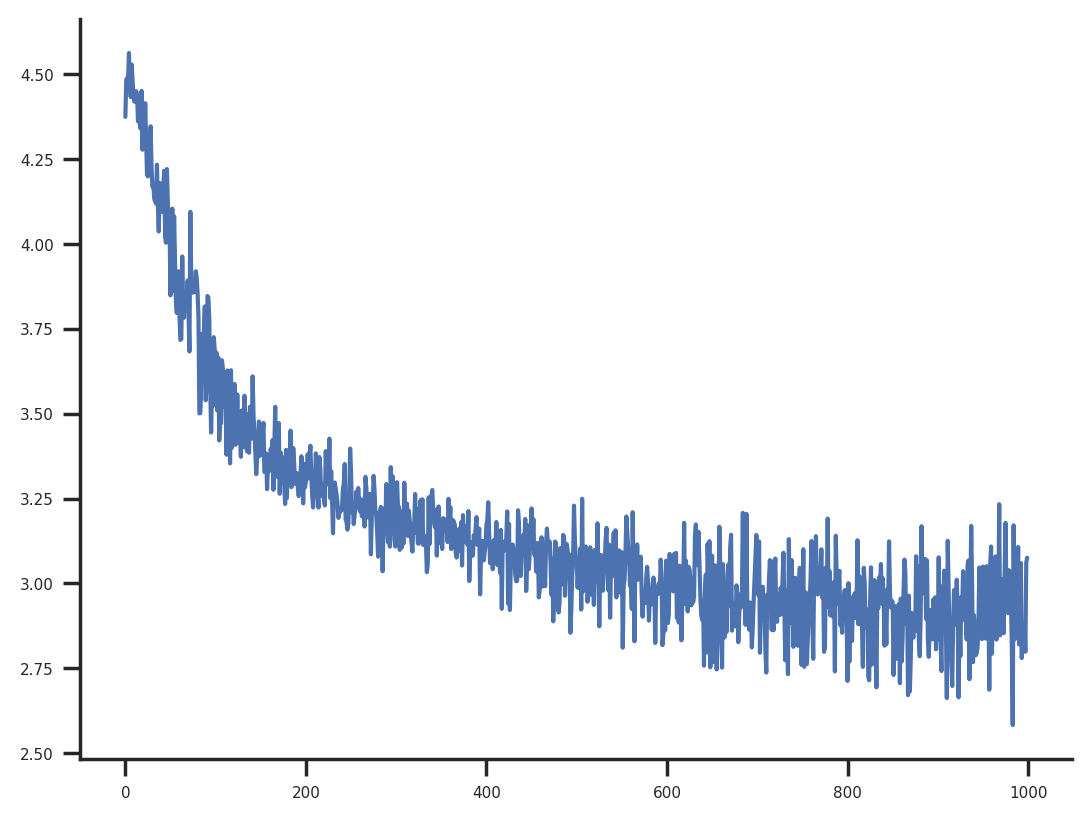

In [42]:
val_acc, loss_list0 = training_loop_concrete(model_self_concrete, data_self_concrete, 1000)
plt.plot(loss_list0)

In [43]:
# checking if genes (features) are selected with high probability 
print(torch.max(F.softmax(model_self_concrete.concrete), axis = 1))

torch.return_types.max(
values=tensor([0.0446, 0.0814, 0.0550, 0.0846, 0.0568, 0.0499, 0.0370, 0.0509, 0.0444,
        0.0549], grad_fn=<MaxBackward0>),
indices=tensor([47, 40, 39, 78, 38, 48, 32, 75, 73, 74]))


/tmp/ipykernel_366646/926117048.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(torch.max(F.softmax(model_self_concrete.concrete), axis = 1))


In [44]:
# Baseline: Train normal GATnet to predict celltypes with self edges
def training_loop(model, data, total_epoch):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()
    loss_list = []
    for epoch in range(1, total_epoch + 1):
        loss = train_gnn(model, optimizer, data, criterion)
        val_acc = test_gnn(model, data)
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Val acc: {val_acc:.4f}")
        loss_list.append(loss.detach().numpy())
    model.eval()
    val_acc = test_gnn(model, data)
    print(f"Self edge accuracy: {val_acc:.4f}")
    return val_acc, loss_list

Epoch: 001, Loss: 4.9046, Val acc: 0.0573
Epoch: 002, Loss: 4.6871, Val acc: 0.0952
Epoch: 003, Loss: 4.5167, Val acc: 0.1363
Epoch: 004, Loss: 4.3919, Val acc: 0.1790
Epoch: 005, Loss: 4.2738, Val acc: 0.2044
Epoch: 006, Loss: 4.1636, Val acc: 0.2244
Epoch: 007, Loss: 4.0645, Val acc: 0.2493
Epoch: 008, Loss: 3.9866, Val acc: 0.2818
Epoch: 009, Loss: 3.8840, Val acc: 0.3104
Epoch: 010, Loss: 3.8358, Val acc: 0.3472
Epoch: 011, Loss: 3.7669, Val acc: 0.3910
Epoch: 012, Loss: 3.6918, Val acc: 0.4246
Epoch: 013, Loss: 3.6092, Val acc: 0.4494
Epoch: 014, Loss: 3.5334, Val acc: 0.4630
Epoch: 015, Loss: 3.4684, Val acc: 0.4754
Epoch: 016, Loss: 3.3849, Val acc: 0.4824
Epoch: 017, Loss: 3.3381, Val acc: 0.4916
Epoch: 018, Loss: 3.2833, Val acc: 0.4938
Epoch: 019, Loss: 3.1994, Val acc: 0.4997
Epoch: 020, Loss: 3.1639, Val acc: 0.5035
Epoch: 021, Loss: 3.0912, Val acc: 0.5084
Epoch: 022, Loss: 3.0315, Val acc: 0.5116
Epoch: 023, Loss: 3.0087, Val acc: 0.5160
Epoch: 024, Loss: 2.9301, Val acc:

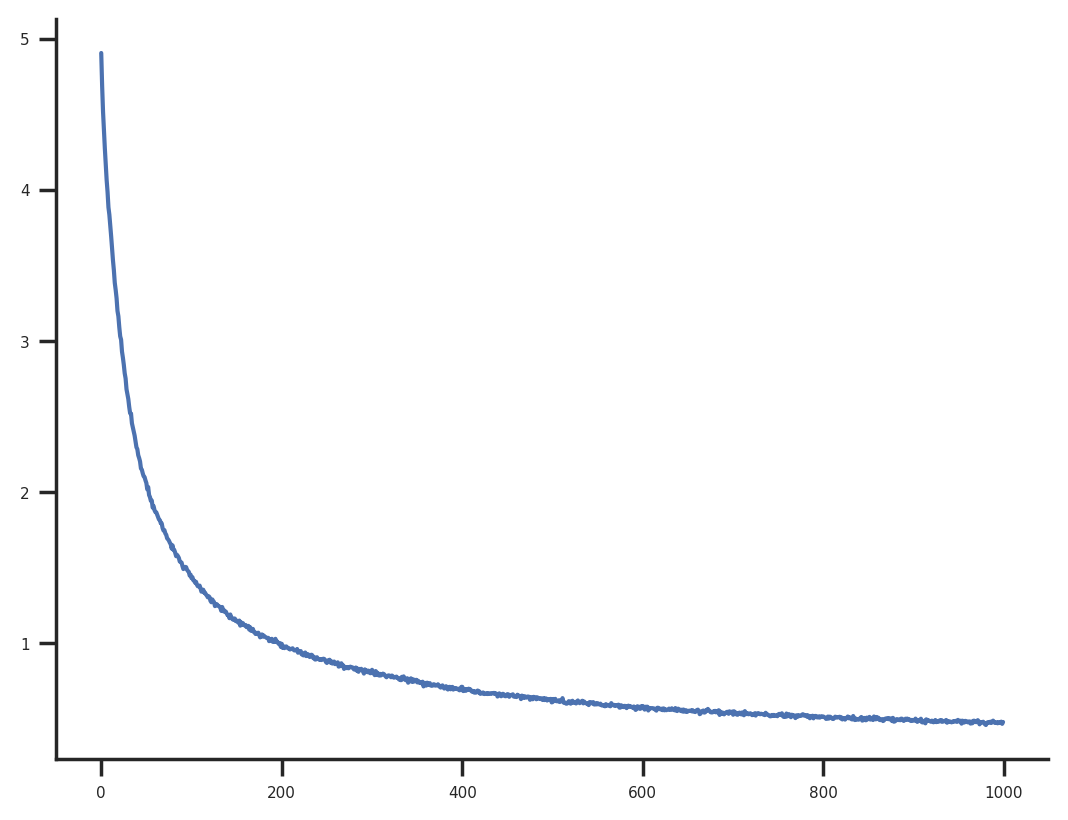

In [45]:
# Baseline: Train normal GATnet to predict celltypes with self edges

val_acc, loss_list = training_loop(model_self, data_self, 1000)
plt.plot(loss_list)

Epoch: 001, Loss: 4.5454, Val acc: 0.0995
Epoch: 002, Loss: 4.3880, Val acc: 0.1130
Epoch: 003, Loss: 4.2501, Val acc: 0.1152
Epoch: 004, Loss: 4.1271, Val acc: 0.1147
Epoch: 005, Loss: 4.0264, Val acc: 0.1174
Epoch: 006, Loss: 3.9484, Val acc: 0.1276
Epoch: 007, Loss: 3.8865, Val acc: 0.1482
Epoch: 008, Loss: 3.8239, Val acc: 0.1996
Epoch: 009, Loss: 3.7526, Val acc: 0.2607
Epoch: 010, Loss: 3.6955, Val acc: 0.2985
Epoch: 011, Loss: 3.6344, Val acc: 0.3299
Epoch: 012, Loss: 3.5775, Val acc: 0.3521
Epoch: 013, Loss: 3.5141, Val acc: 0.3645
Epoch: 014, Loss: 3.4589, Val acc: 0.3737
Epoch: 015, Loss: 3.3905, Val acc: 0.3807
Epoch: 016, Loss: 3.3324, Val acc: 0.3824
Epoch: 017, Loss: 3.2737, Val acc: 0.3851
Epoch: 018, Loss: 3.2154, Val acc: 0.3872
Epoch: 019, Loss: 3.1661, Val acc: 0.3921
Epoch: 020, Loss: 3.1186, Val acc: 0.3899
Epoch: 021, Loss: 3.0748, Val acc: 0.3948
Epoch: 022, Loss: 3.0477, Val acc: 0.3981
Epoch: 023, Loss: 3.0302, Val acc: 0.3964
Epoch: 024, Loss: 2.9894, Val acc:

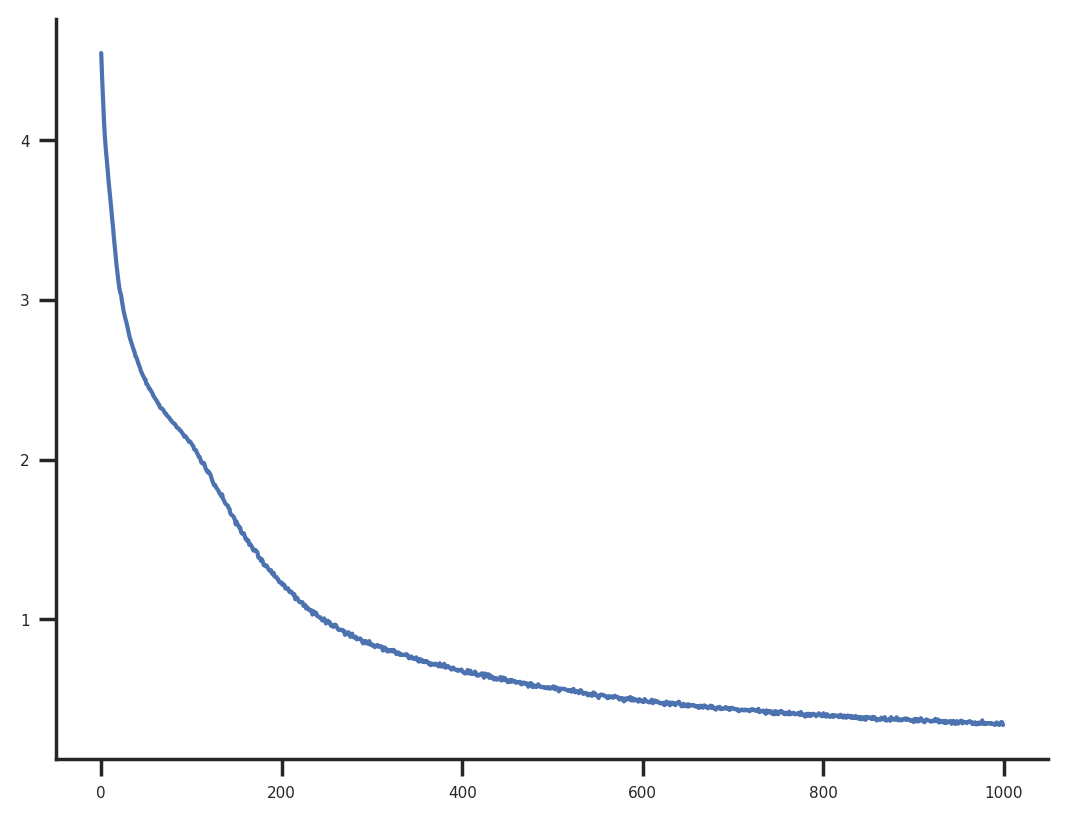

In [46]:
# Baseline: Train normal GATnet to predict celltypes with knn edges

val_acc, loss_list2 = training_loop(model_knn, data_knn, 1000)
plt.plot(loss_list2)

In [47]:
# Predict cell types with genes (no graph) --> baseline
def linear_predict(y_str, x, adata, random_state):
    y = adata.obs.loc[:, y_str]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

    # scale input - regularization with logistic regression is sensitive to scale.
    model = make_pipeline(StandardScaler(), LogisticRegression(random_state=random_state))
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    return acc_train, acc_test



In [48]:
linear_predict("supertype", one_sec_x, one_sec, 0)

(1.0, 0.8734451054624122)